In [337]:

from tqdm.notebook import tqdm

from graphs import *
from linear_regression_experiements.data.adult import get_adult_dataset
from linear_regression_experiements.data.hospital import get_hospital_dataset
from utils.algorithm import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [338]:
utility_type = "inverse"
if utility_type == "linear":
    utility = lambda x: -x
elif utility_type == "inverse":
    utility = lambda x: 1 / (1 + x)
else:
    raise NotImplementedError
W_iter = 20
threshold_task_sim = -1
threshold_task_diff = 0.1

In [339]:
def get_dataset(dataset: str) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    if dataset == 'adult':
        return get_adult_dataset()
    elif dataset == "hospital":
        return get_hospital_dataset()
    else:
        del Xs_train, Xs_test, ys_train, ys_test
        raise NotImplementedError(f'Dataset {dataset} not implemented')


Xs_train, Xs_test, ys_train, ys_test = get_dataset("hospital")
print(f"There is {len(Xs_train)} clients and {Xs_train[0].shape[1]} features")
print(f"Number of training samples: {list(map(lambda x: x.shape[0], Xs_train))}")
print(f"Number of test samples: {list(map(lambda x: x.shape[0], Xs_test))}")

There is 45 clients and 21 features
Number of training samples: [18976, 7729, 7372, 6631, 6552, 5712, 5093, 4576, 4187, 4166, 3430, 3329, 3036, 2840, 2720, 2613, 2404, 2356, 2314, 2308, 1837, 1731, 1629, 1614, 1605, 1492, 1460, 1274, 1251, 1128, 1068, 983, 929, 752, 749, 713, 680, 676, 675, 629, 611, 607, 585, 506, 451]
Number of test samples: [4744, 1933, 1843, 1658, 1639, 1429, 1274, 1144, 1047, 1042, 858, 833, 760, 710, 681, 654, 602, 590, 579, 578, 460, 433, 408, 404, 402, 374, 366, 319, 313, 282, 267, 246, 233, 189, 188, 179, 171, 169, 169, 158, 153, 152, 147, 127, 113]


In [340]:
betas_local, std_squared, sizes = train(Xs_train, ys_train)
task_difficulty = std_squared
prune_task_idx = np.arange(betas_local.shape[0])[task_difficulty < threshold_task_diff]
betas_local = betas_local[prune_task_idx]
task_difficulty = task_difficulty[prune_task_idx]
std_squared = std_squared[prune_task_idx]
sizes = sizes[prune_task_idx]
Xs_train = [Xs_train[idx] for idx in prune_task_idx]
Xs_test = [Xs_test[idx] for idx in prune_task_idx]
ys_train = [ys_train[idx] for idx in prune_task_idx]
ys_test = [ys_test[idx] for idx in prune_task_idx]

print(f"{45 - betas_local.shape[0]} hospital removed")

0 hospital removed


In [341]:
collab_betas_local = betas_local
collab_task_difficulty = task_difficulty
collab_std_squared = std_squared
collab_sizes = sizes
collab_Xs_train = Xs_train
collab_Xs_test = Xs_test
collab_ys_train = ys_train
collab_ys_test = ys_test

cos_sim = (collab_betas_local @ collab_betas_local.T) / (
            np.linalg.norm(collab_betas_local, axis=1).reshape(collab_betas_local.shape[0], 1) * np.linalg.norm(
        collab_betas_local, axis=1).reshape(1, collab_betas_local.shape[0]))
while np.any(cos_sim.mean(axis=1) < threshold_task_sim):
    cos_sim = (collab_betas_local @ collab_betas_local.T) / (
                np.linalg.norm(collab_betas_local, axis=1).reshape(collab_betas_local.shape[0], 1) * np.linalg.norm(
            collab_betas_local, axis=1).reshape(1, collab_betas_local.shape[0]))
    indices = np.argsort(cos_sim.mean(axis=1))[1:]
    collab_task_difficulty = collab_task_difficulty[indices]
    collab_std_squared = collab_std_squared[indices]
    collab_sizes = collab_sizes[indices]
    collab_Xs_train = [collab_Xs_train[idx] for idx in indices]
    collab_Xs_test = [collab_Xs_test[idx] for idx in indices]
    collab_ys_train = [collab_ys_train[idx] for idx in indices]
    collab_ys_test = [collab_ys_test[idx] for idx in indices]
    collab_betas_local = collab_betas_local[indices, :]

print(f"{betas_local.shape[0] - collab_betas_local.shape[0]} hospital removed")

0 hospital removed


In [342]:
exp_gains = []
exp_mse = []
exp_fair_gains = []
exp_task_difficulty = []
exp_contributions = []
mse_local = None

for iter in tqdm(range(1, W_iter + 1)):
    Ws = OLS_iterative_fusion(collab_betas_local, collab_std_squared, num_iter=iter)
    betas_fusion = get_fusion_betas(collab_betas_local, Ws)
    betas_fair_fusion, C, noise = get_fair_fusion_betas(collab_betas_local, Ws, collab_std_squared)
    mse_local = get_mse(collab_Xs_test, collab_ys_test, collab_betas_local)
    mse_fusion = get_mse(collab_Xs_test, collab_ys_test, betas_fusion)
    mse_fair_fusion_mean, mse_fair_fusion_var = get_expected_fair_mse(collab_betas_local, Ws, collab_std_squared,
                                                                      collab_Xs_test, collab_ys_test)
    gains = utility(mse_fusion) - utility(mse_local)
    fair_gains = utility(mse_fair_fusion_mean) - utility(mse_local)

    exp_mse.append(mse_fusion)
    exp_gains.append(gains)
    exp_fair_gains.append(fair_gains)
    exp_task_difficulty.append(collab_task_difficulty)
    exp_contributions.append(C)

  0%|          | 0/20 [00:00<?, ?it/s]

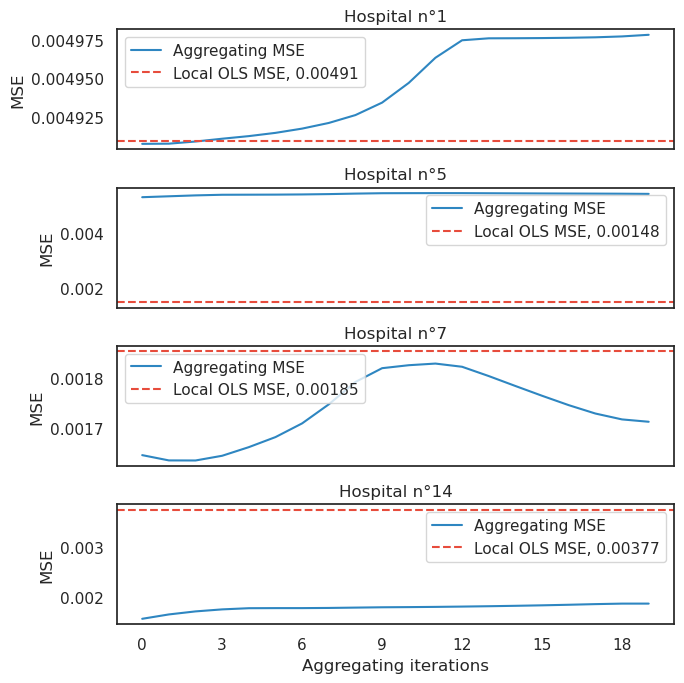

In [343]:
plot_evolution(exp_mse, mse_local, save_path="img/W_iter_local_agg.png")

In [344]:
exp_mse_count = [mse < mse_local for mse in exp_mse]
exp_mse_count_val = np.array([np.sum(mse) for mse in exp_mse_count])
exp_mse_count_val

array([24, 20, 13, 11, 10,  9,  7,  5,  6,  5,  6,  5,  4,  4,  3,  5,  3,
        3,  3,  3])

In [345]:
exp_mse_gain = [mse_local - mse for mse in exp_mse]
exp_mse_gain_val = np.array([np.median(mse) for mse in exp_mse_gain])
exp_mse_gain_val

array([ 2.88784896e-06, -1.14214093e-05, -2.64250674e-05, -4.29493148e-05,
       -6.80379695e-05, -1.17009887e-04, -1.38827421e-04, -1.57999523e-04,
       -2.14857085e-04, -2.56361007e-04, -2.45968412e-04, -2.52061743e-04,
       -2.75090669e-04, -2.96166613e-04, -3.32909078e-04, -3.79002709e-04,
       -3.99265165e-04, -4.27279871e-04, -4.73170320e-04, -5.14184391e-04])

In [346]:
exp_mse_gain_pos = [exp_mse[i][exp_mse_count[i]].mean() for i in range(len(exp_mse_count))]
best_iter = np.argmax(exp_mse_gain_pos)
best_iter, exp_mse_count[best_iter].sum()

(7, 5)

In [347]:
best_iter = 1
indices = np.arange(collab_betas_local.shape[0])[exp_mse_count[best_iter]]
task_difficulty_pos_gain = collab_task_difficulty[indices]
std_squared_pos_gain = collab_std_squared[indices]
sizes_pos_gain = collab_sizes[indices]
Xs_train_pos_gain = [collab_Xs_train[idx] for idx in indices]
Xs_test_pos_gain = [collab_Xs_test[idx] for idx in indices]
ys_train_pos_gain = [collab_ys_train[idx] for idx in indices]
ys_test_pos_gain = [collab_ys_test[idx] for idx in indices]
betas_local_pos_gain = collab_betas_local[indices, :]
mse_local_pos_gain = mse_local[indices]
gain_pos_gain = exp_gains[best_iter][indices]
fair_gain_pos_gain = exp_fair_gains[best_iter][indices]
contributions_pos_gain = exp_contributions[best_iter][indices]

In [348]:
task_difficulty_all = collab_task_difficulty
std_squared_all = collab_std_squared
sizes_all = collab_sizes
betas_local_all = collab_betas_local
mse_local_all = mse_local
gain_all = exp_gains[best_iter]
fair_gain_all = exp_fair_gains[best_iter]
contributions_all = exp_contributions[best_iter]

In [349]:
Ws = OLS_iterative_fusion(betas_local_pos_gain, std_squared_pos_gain, num_iter=2)
betas_fusion = get_fusion_betas(betas_local_pos_gain, Ws)
betas_fair_fusion, C, noise = get_fair_fusion_betas(betas_local_pos_gain, Ws, std_squared_pos_gain)
mse_local = get_mse(Xs_test_pos_gain, ys_test_pos_gain, betas_local_pos_gain)
mse_fusion = get_mse(Xs_test_pos_gain, ys_test_pos_gain, betas_fusion)
mse_fair_fusion_mean, mse_fair_fusion_var = get_expected_fair_mse(betas_local_pos_gain, Ws, std_squared_pos_gain,
                                                                  Xs_test_pos_gain, ys_test_pos_gain)
gains = utility(mse_fusion) - utility(mse_local)
fair_gains = utility(mse_fair_fusion_mean) - utility(mse_local)

In [350]:
mse_local - exp_mse[best_iter][indices], mse_local - mse_fusion

(array([2.03604530e-06, 6.82952843e-06, 6.12894383e-06, 3.76434043e-05,
        3.93399914e-06, 6.14356613e-05, 8.64746204e-05, 1.06582667e-05,
        1.21265824e-04, 3.66325636e-05, 2.00007022e-05, 7.01130347e-06,
        2.08289467e-06, 3.03063753e-05, 2.57657170e-04, 6.31704810e-05,
        5.07805929e-05, 1.21960358e-04, 9.40195812e-05, 2.55026960e-05]),
 array([-9.81800647e-07, -1.04927748e-05, -2.37985180e-05,  2.29535865e-05,
        -3.00627377e-05,  1.06249015e-04, -2.96357069e-05, -1.43727977e-04,
        -2.44263252e-05,  2.81584508e-05, -3.86393449e-05, -1.07370906e-04,
        -9.86569516e-05, -2.11153274e-05,  2.59905090e-04, -1.66805265e-04,
        -2.52175383e-04,  3.16209427e-05, -1.20150381e-04, -1.52488943e-05]))

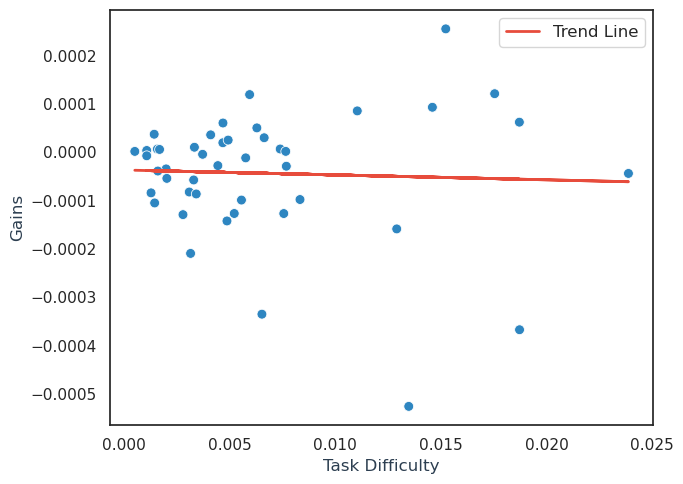

In [351]:
plot_corr([task_difficulty_all], [gain_all], "Task Difficulty", "Gains", "",
          save_path=f"img/{utility_type}_contr_vs_gain_all")

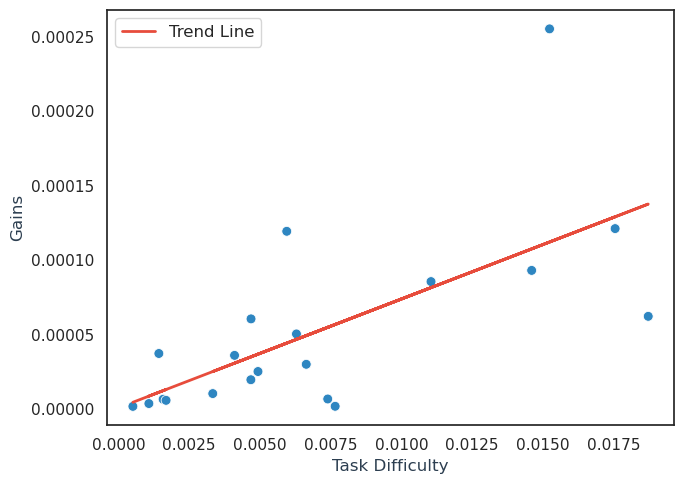

In [352]:
plot_corr([task_difficulty_pos_gain], [gain_pos_gain], "Task Difficulty", "Gains", "",
          save_path=f"img/{utility_type}_contr_vs_gain_pos")

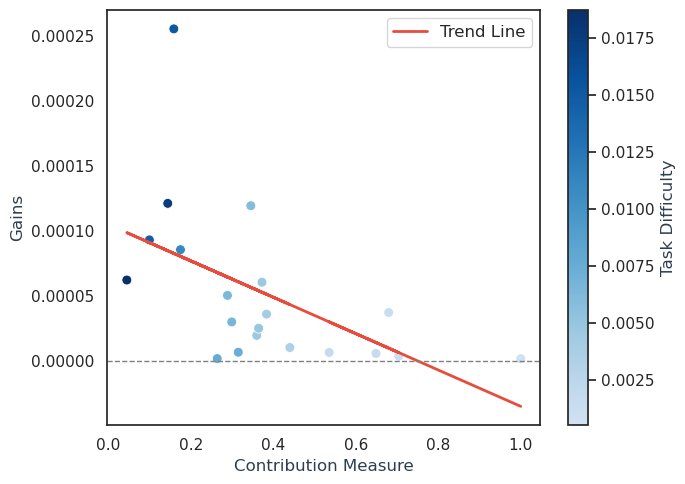

In [353]:
plot_corr([contributions_pos_gain], [gain_pos_gain], "Contribution Measure", "Gains", "",
          save_path=f"img/{utility_type}_contr_vs_gain_w_pos_hue_diff", hue_control=[task_difficulty_pos_gain],
          hue_label="Task Difficulty", y_0=True)

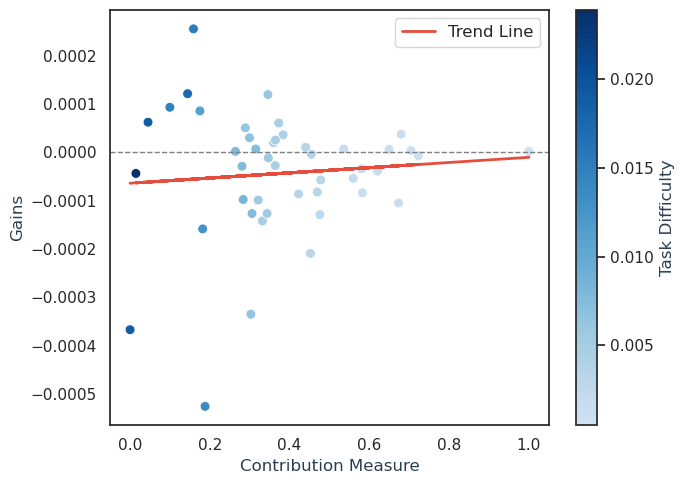

In [354]:
plot_corr([contributions_all], [gain_all], "Contribution Measure", "Gains", "",
          save_path=f"img/{utility_type}_contr_vs_gain_w_all_hue_diff", hue_control=[task_difficulty_all],
          hue_label="Task Difficulty", y_0=True)

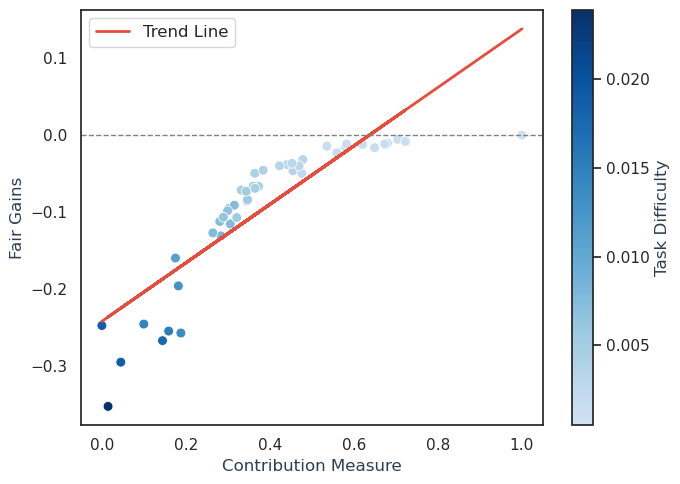

In [355]:
plot_corr([contributions_all], [fair_gain_all], "Contribution Measure", "Fair Gains", "",
          save_path=f"img/{utility_type}_contr_vs_fair_gain_w_all_hue_diff", hue_control=[task_difficulty_all],
          hue_label="Task Difficulty", y_0=True)

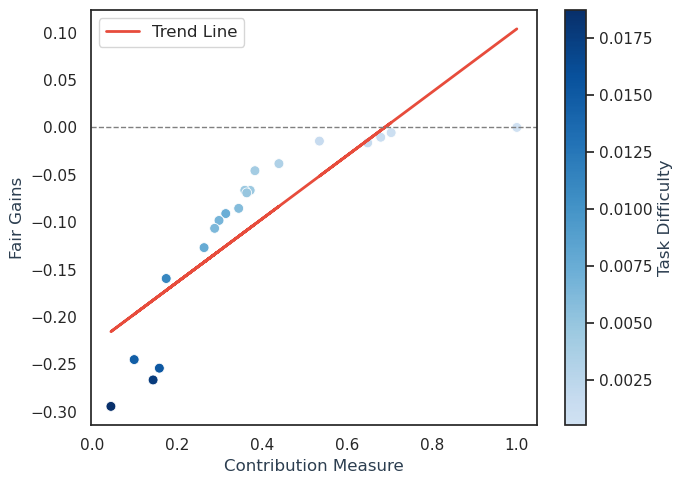

In [356]:
plot_corr([contributions_pos_gain], [fair_gain_pos_gain], "Contribution Measure", "Fair Gains", "",
          save_path=f"img/{utility_type}_contr_vs_fair_gain_w_pos_hue_diff", hue_control=[task_difficulty_pos_gain],
          hue_label="Task Difficulty", y_0=True)